In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from upapy.io import load_data
from upapy.reconstruction.ubp2d import FastUBP
from focus_func import *

In [2]:
# 批量重构函数
def batch_reconstruct(
    data: np.ndarray, sos: float = 1.5, image_size: int = 30, half_time: int = 0
) -> np.ndarray:
    if data.ndim == 3:
        fubp = FastUBP()
        fubp.set_pa_frame_element_number(data.shape[1])
        fubp.set_reconstruction_water_sos(sos)
        fubp.set_reconstruction_tissue_sos(sos)
        fubp.set_image_length(image_size)
        fubp.set_image_width(image_size)
        fubp.set_control_half_time_delta(half_time)
        recon_list = []
        for i in range(data.shape[0]):
            recon_slice = fubp.reconstruction(data[i])
            recon_list.append(recon_slice)
        return np.array(recon_list)
    else:
        raise ValueError("Incorrect array dimension.")

In [3]:
raw_data = load_data("../data/mouse_data/D11980_1064 nm_30 %_20db_mouse_000.pah5")
raw_data = raw_data[50:150]
raw_data.shape

(100, 512, 2000)

In [4]:
recon_list = []
for sos in np.arange(1.40, 1.60, 0.005):
    recon = batch_reconstruct(raw_data, sos)
    recon_list.append(recon)
recon = np.array(recon_list)
recon.shape

(41, 100, 750, 750)

In [5]:
data = recon.transpose(1, 0, 2, 3)
data.shape

(100, 41, 750, 750)

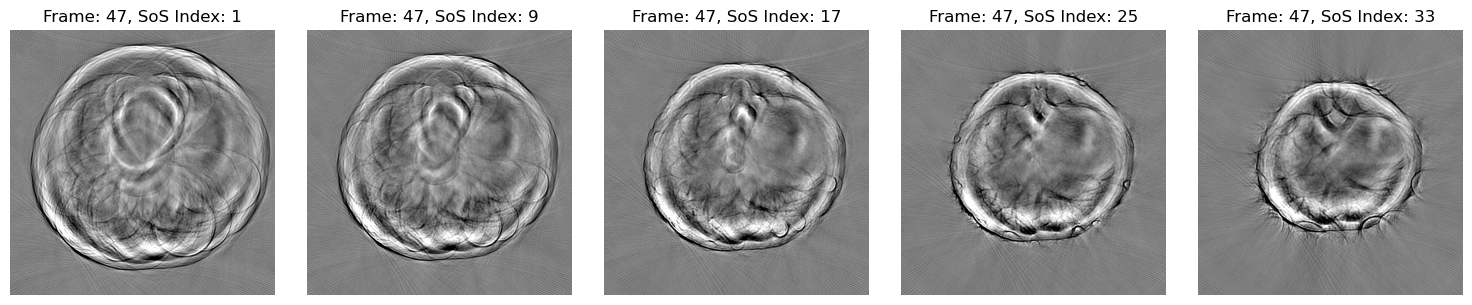

In [6]:
# 测试查看图像
n_rows = 1  # 行数
n_cols = 5  # 列数

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

# 确保 axes 是二维数组（如果只有一行）
if n_rows == 1:
    axes = axes.reshape(1, -1)

frame_idx = np.random.randint(0, data.shape[0])
for i in range(n_rows):
    for j in range(n_cols):  # 随机选择一帧图像
        sos_idx = i * n_cols + j * math.floor(data.shape[1] / (n_rows * n_cols))  # 计算声速索引

        img = data[frame_idx, sos_idx, :, :]
        axes[i, j].imshow(img, cmap='gray', vmin=-10, vmax=10)
        axes[i, j].set_title(f'Frame: {frame_idx + 1}, SoS Index: {sos_idx + 1}')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# 绘图函数
def plot_gradient(gradients, title="Gradient_Line", save_path=None):
    """
    绘制梯度值的曲线图

    参数:
    gradients (numpy.ndarray): 包含梯度值的一维数组
    title (str): 图表标题
    save_path (str): 保存图表的路径，若为None则显示图表而不保存
    """
    # 创建图表
    plt.figure(figsize=(8, 6))

    # 绘制梯度值曲线
    plt.plot(gradients, marker='o', linestyle='-', markersize=3, alpha=0.7)

    # 添加标题和标签
    plt.title(title, fontsize=15)
    plt.xlabel('Index', fontsize=12)
    plt.ylabel('Gradient', fontsize=12)

    # 添加网格线
    plt.grid(True, linestyle='--', alpha=0.7)

    # 找出最大梯度值及其索引
    max_gradient = np.max(gradients)
    max_index = np.argmax(gradients)

    # 在图上标记最大值点
    plt.scatter(max_index, max_gradient, color='red', s=100, zorder=5)
    plt.annotate(f'MAX: {max_gradient:.2f}\nMAX_Index: {max_index}',
                 xy=(max_index, max_gradient),
                 xytext=(max_index+10, max_gradient+0.1*max_gradient),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=10)

    # 设置x轴刻度间隔
    if len(gradients) > 50:
        plt.xticks(range(0, len(gradients), len(gradients)//10))

    # 调整布局
    plt.tight_layout()

    # 保存或显示图表
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved: {save_path}")
    else:
        plt.show()

def plot_derivative(data, title="Derivative Plot"):
    """
    绘制数据的差分曲线，并标记与零线的交点

    参数:
    data_raw: 输入数据数组
    title: 图表标题
    """
    # 计算差分
    derivarive = np.gradient(data)

    # 创建X轴坐标
    x = np.arange(len(derivarive))

    # 创建差分曲线的插值函数，用于更精确地找到交点
    f = interp1d(x, derivarive, kind='linear', fill_value="extrapolate")

    # 找到差分与零线的交点
    intersections = []
    for i in range(len(x) - 1):
        if (derivarive[i] <= 0 and derivarive[i+1] >= 0) or (derivarive[i] >= 0 and derivarive[i+1] <= 0):
            # 使用线性插值计算更精确的交点位置
            x_intersect = x[i] - derivarive[i] * (x[i+1] - x[i]) / (derivarive[i+1] - derivarive[i])
            intersections.append((x_intersect, 0))

    # 绘制差分曲线
    plt.figure(figsize=(8, 6))
    plt.plot(x, derivarive, 'b-', linewidth=2, label='Gradient')

    # 绘制零线
    plt.axhline(y=0, color='r', linestyle='-', linewidth=1.5, label='Zero Line')

    # 标记交点
    for x_val, y_val in intersections:
        plt.plot(x_val, y_val, 'go', markersize=8, label=f'Intersection at ({x_val:.2f}, {y_val})' if intersections.index((x_val, y_val)) == 0 else "")
        plt.text(x_val, y_val+0.05, f'({x_val:.2f}, {y_val})', fontsize=9)

    # 设置图表属性
    xlabel = "X Axis"
    ylabel = "Gradient"

    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

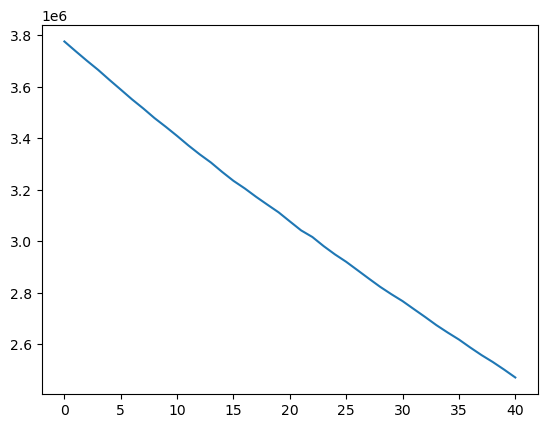

In [8]:
# 针对单帧计算聚焦函数并绘图
idx = np.random.randint(0, data.shape[0])

gradients = calculate_brenner_gradient(data[idx, :, :, :])  # 针对全局图像计算
# gradients = calculate_brenner_gradient(data_raw[idx, :, 250:500, 250:500])  # 针对中心图像计算
# print(gradients)
plt.plot(gradients)

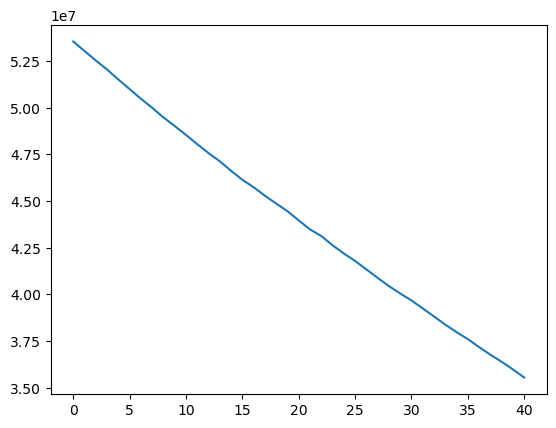

In [9]:
gradients = calculate_tenenbaum_gradient(data[idx, :, :, :])
# gradients = calculate_tenenbaum_gradient(data_raw[idx, :, 250:500, 250:500])
# print(gradients)
plt.plot(gradients)

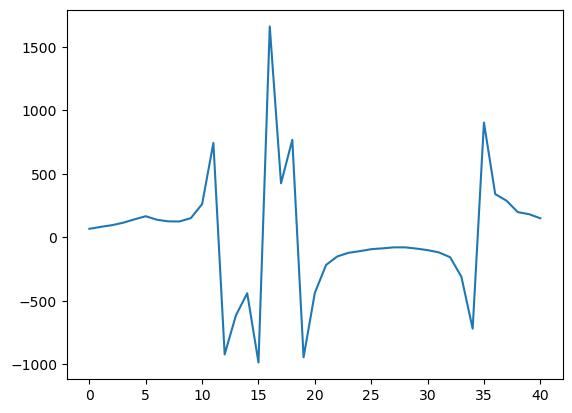

In [10]:
gradients = calculate_normalized_variance(data[idx, :, :, :])
# gradients = calculate_normalized_variance(data_raw[idx, :, 250:500, 250:500])
# print(gradients)
plt.plot(gradients)

In [11]:
# 针对多帧图像计算 PIM 后再计算聚焦函数
mip_list = []
for item in recon:
    mip = np.max(-item, axis=0)
    mip_list.append(mip)
mips = np.array(mip_list)

print(mips.shape)

(41, 750, 750)


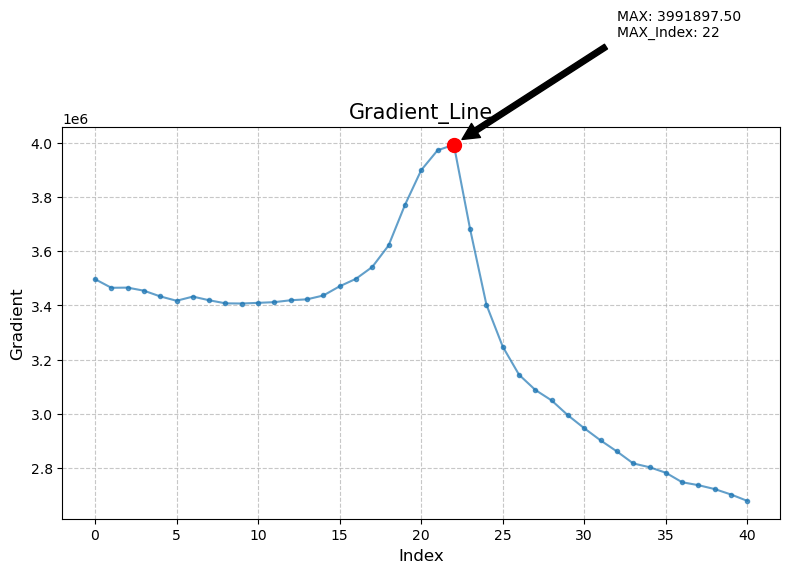

In [12]:
gradients = calculate_brenner_gradient(mips)
# print(gradients)
plot_gradient(gradients)

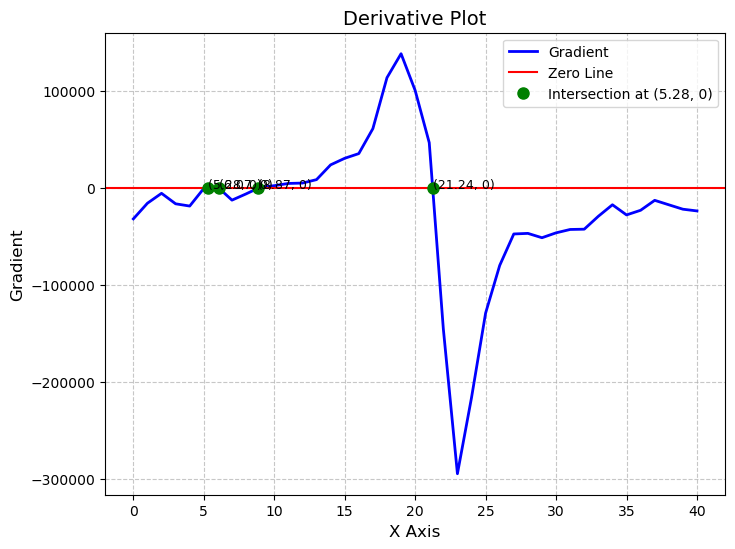

In [13]:
plot_derivative(gradients)

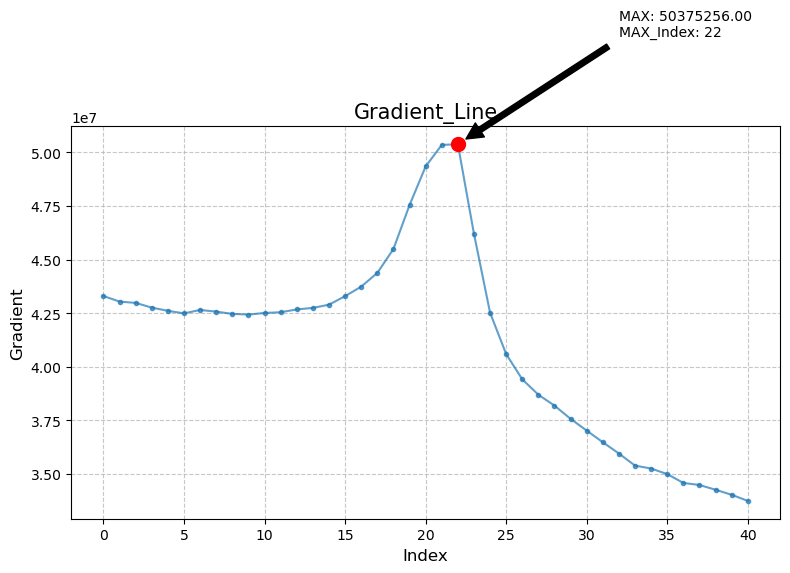

In [14]:
gradients = calculate_tenenbaum_gradient(mips)
# print(gradients)
plot_gradient(gradients)

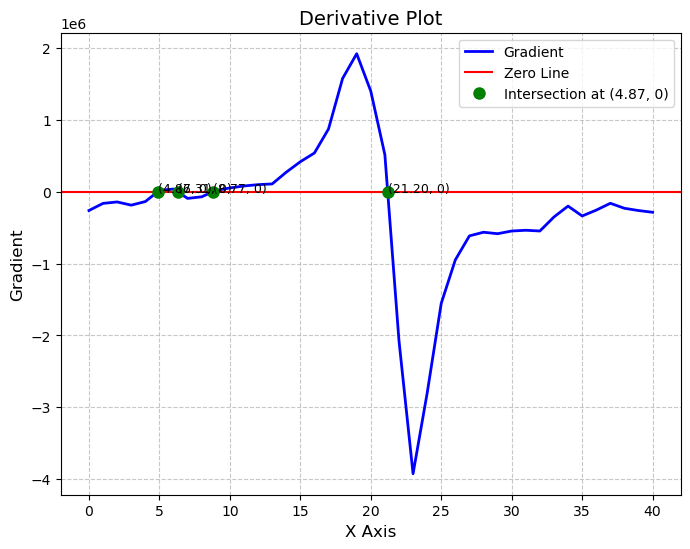

In [15]:
plot_derivative(gradients)

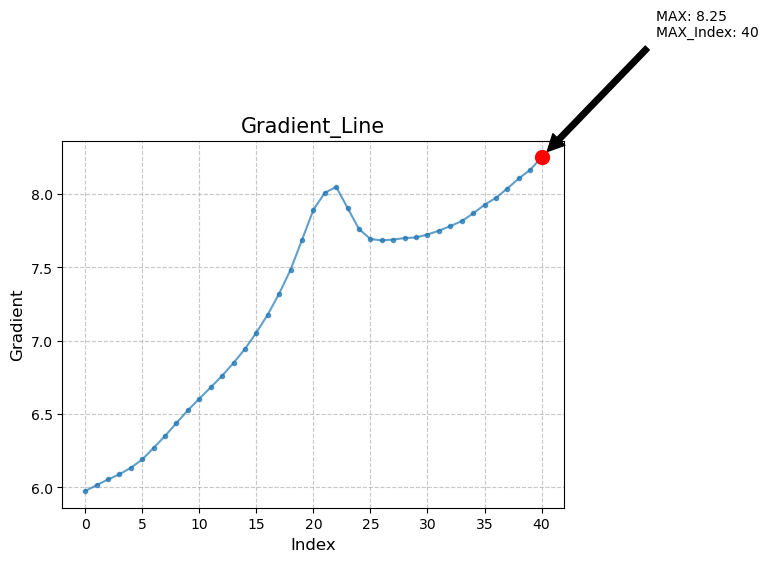

In [16]:
gradients = calculate_normalized_variance(mips)
# print(gradients)
plot_gradient(gradients)

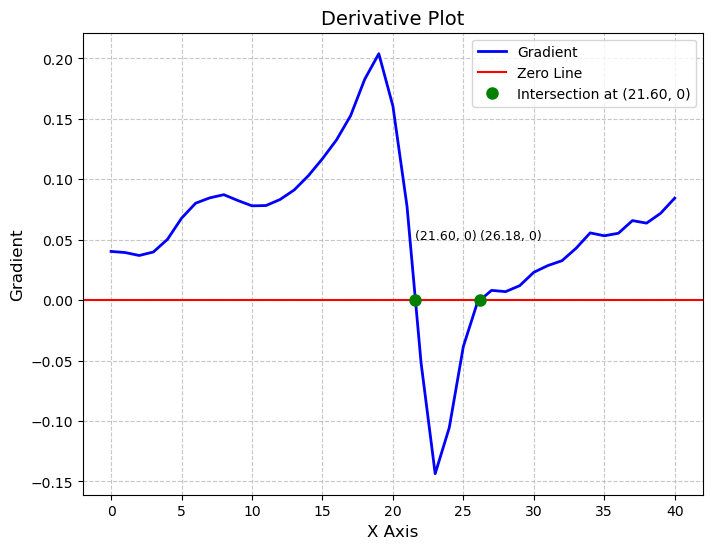

In [17]:
plot_derivative(gradients)